In [1]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import getpass
from pymarkovchain import MarkovChain
from functions import *
np.set_printoptions(precision=2)
pd.set_option('precision', 2)
%matplotlib inline
matplotlib.style.use('ggplot')

### Load data

In [2]:
df = pd.read_csv('C:\Users\\'+getpass.getuser()+'\\Google Drive\Sarah Ido folder\data\CCK\MATCHING_phet_cck_user_actions+sophistication_WITHPAUSE_anonymized.txt')
df_scores = pd.read_csv('C:\Users\\'+getpass.getuser()+'\\Google Drive\Sarah Ido folder\data\CCK\MATCHING_phet_cck_user_data_anonymized.txt')
df["student"] = df["student"].astype('category')
df_scores["student"] = df_scores["student"].astype('category')
df["Family"]=df["Family"].str.capitalize()

def remodel_families(row):
    if row["Family"] == "Build" or row["Family"] == "Revise" or row["Family"] == "Extra":
        if row["Outcome"] != "None":
            return "ConstructWithFeedback"
        else:
            return "Construct"
    else:
        return row["Family"]
    
df['Family'] = df.apply (lambda row: remodel_families (row),axis=1)

Here we set up some paramters

In [3]:
ACTIONS_TO_REMOVE = ['I', 'O','S','']

###  Some functions that we use later

In [4]:
def get_markov_chains(df,activity, attribute=None, level=None):
    df2 = df[df.Activity == activity]
    blocks = get_blocks(df2,get_students(),add_spaces = True)
    if attribute:
        blocks = select_blocks(blocks, attribute, level)
    seqs = '.'.join(blocks.values())

    mc = MarkovChain()
    mc.generateDatabase(seqs)
    return mc.db

def make_graph_from_chain(chain_probs):
    G = nx.Graph()
    for last_actions,probs in chain_probs.iteritems():
        if len(last_actions) == 1:
            last_action = last_actions[0]
            for next_action,p in probs.iteritems():
                G.add_edge(last_action, next_action, weight = p)
    G.remove_nodes_from(ACTIONS_TO_REMOVE)
    return G

def plot_graph(G, pos = None):
    if pos == None:
        pos = nx.circular_layout(G)
    nx.draw_networkx_nodes(G,pos,node_size=700,node_color='#cccccc')
    nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')
    # labels = nx.get_edge_attributes(G,'weight')
    # nx.draw_networkx_edge_labels(G,pos,edge_labels={k:round(v,3) for k,v in labels.iteritems()})

    cut1 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 20)
    cut2 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 40)
    cut3 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 60)
    cut4 = np.percentile(nx.get_edge_attributes(G,'weight').values(), 80)

    esmall = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= cut1]
    emedium = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut1 and d['weight'] <= cut2]
    elarge = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut2 and d['weight'] <= cut3]
    ehuge = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut3 and d['weight'] <= cut4]
    enormous = [(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > cut4]
    
    colors = ["#c7e9b4","#7fcdbb","#41b6c4","#2c7fb8","#253494"]

    nx.draw_networkx_edges(G,pos,edgelist=esmall,width=3,alpha=1,edge_color=colors[0])
    nx.draw_networkx_edges(G,pos,edgelist=emedium,width=6,alpha=1,edge_color=colors[1])
    nx.draw_networkx_edges(G,pos,edgelist=elarge,width=9,alpha=1,edge_color=colors[2])
    nx.draw_networkx_edges(G,pos,edgelist=ehuge,width=12,alpha=1,edge_color=colors[3])
    nx.draw_networkx_edges(G,pos,edgelist=enormous,width=15,alpha=1,edge_color=colors[4])
    plt.axis('off')
    return pos

### Get sequences
Add to the markov chain sentences where each sentence is a student seqence and each word is an action.

In [5]:
chain_probs1_scaff = get_markov_chains(df,'a1','scaffolding','scaff')
chain_probs1_not = get_markov_chains(df,'a1','scaffolding','not')
chain_probs2_scaff = get_markov_chains(df,'a2','scaffolding','scaff')
chain_probs2_not = get_markov_chains(df,'a2','scaffolding','not')

### Create the graph from markov probabilities

In [7]:
G_1_scaff = make_graph_from_chain(chain_probs1_scaff)
G_1_not = make_graph_from_chain(chain_probs1_not)
G_2_scaff = make_graph_from_chain(chain_probs2_scaff)
G_2_not = make_graph_from_chain(chain_probs2_not)

### Visualize!

{'C': array([ 1.,  0.]),
 'F': array([ 0.31,  0.95]),
 'P': array([-0.81,  0.59]),
 'T': array([-0.81, -0.59]),
 'X': array([ 0.31, -0.95])}

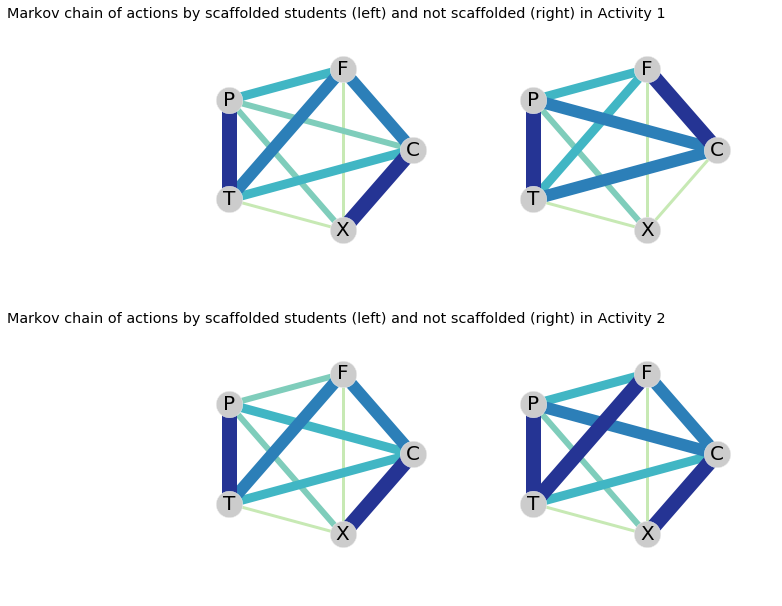

In [8]:
plt.figure(figsize=(10,10))
plt.subplot(2, 2, 1)
pos = plot_graph(G_1_scaff) #keep the same node position for all graphs
plt.title('Markov chain of actions by scaffolded students (left) and not scaffolded (right) in Activity 1')
plt.subplot(2, 2, 2)
plot_graph(G_1_not, pos=pos)
plt.subplot(2, 2, 3)
plot_graph(G_2_scaff, pos=pos)
plt.title('Markov chain of actions by scaffolded students (left) and not scaffolded (right) in Activity 2')
plt.subplot(2, 2, 4)
plot_graph(G_2_not, pos=pos)

In activity 1 (graphs in top row) students that were scaffolded tended to:
* Pause and Construct w feedback successively more often, whereas non scaffolded students Pause and Construct w/ Feedback more.
* Reset and Construct w Feedback successively more often.
* Test and Construct w Feedback successively more often.

### Do these differences persist in Activity 2?

No!

* Everyone Pause and Construct w/ feedback more than with feedback (change for scaffolded students)
* Everyone Reset and Construct w Feedback successively more often (change for non scaffolded students).
* Non scaffolded students now Test and Construct w feedback more than w/, while scaffolded students already did this.

## Now let's split by learning gains in activity 2
So far, nothing surprising. Let's student actions given learning gains in activity 2.

In [12]:
# chain_probs1_high = get_markov_chains(df,'a1','learning2','high')
# chain_probs1_low = get_markov_chains(df,'a1','learning2','low')
chain_probs2_high = get_markov_chains(df,'a2','learning2','high')
chain_probs2_low = get_markov_chains(df,'a2','learning2','low')

In [13]:
# G_1_high = make_graph_from_chain(chain_probs1_high)
# G_1_low = make_graph_from_chain(chain_probs1_low)
G_2_high = make_graph_from_chain(chain_probs2_high)
G_2_low = make_graph_from_chain(chain_probs2_low)

{'C': array([ 1.,  0.]),
 'F': array([ 0.31,  0.95]),
 'P': array([-0.81,  0.59]),
 'T': array([-0.81, -0.59]),
 'X': array([ 0.31, -0.95])}

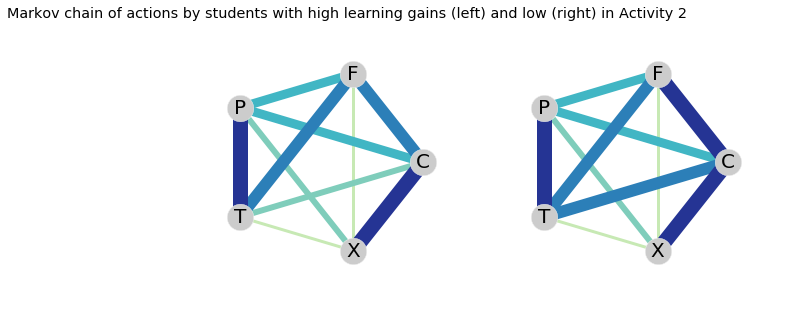

In [14]:
plt.figure(figsize=(10,5))
# plt.subplot(2, 2, 1)
# plot_graph(G_1_high,pos=pos) #keep the same node position for all graphs
# plt.title('Markov chain of actions by students with high learning gains (left) and low (right) in Activity 1')
# plt.subplot(2, 2, 2)
# plot_graph(G_1_low, pos=pos)
plt.subplot(1, 2, 1)
plot_graph(G_2_high, pos=pos)
plt.title('Markov chain of actions by students with high learning gains (left) and low (right) in Activity 2')
plt.subplot(1, 2, 2)
plot_graph(G_2_low, pos=pos)

In activity 2, Students with low learning gains tended to do these actions together more:
* Construct w feedback and Construct w/ feedback
* Test and Construct w/ feedback